# rare events meet smote strategies
- characteristics: sparse outcome (mostly zeros), small effects, high uncertainty
- smote strategies : (sparseness-level * smote level * undersampling level) * algorithm -> recall(1s), precision(1s) curves (orange, blue); x-axis smote level in 5% increments, stacked vertically according to sparseness level

this script:
1) demonstrates the separate effects of sparseness level and SMOTE on precision, recall and f1 score
2) tries out logistic regression and xgboost models, in default mode and with hyperparameter tuning

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot

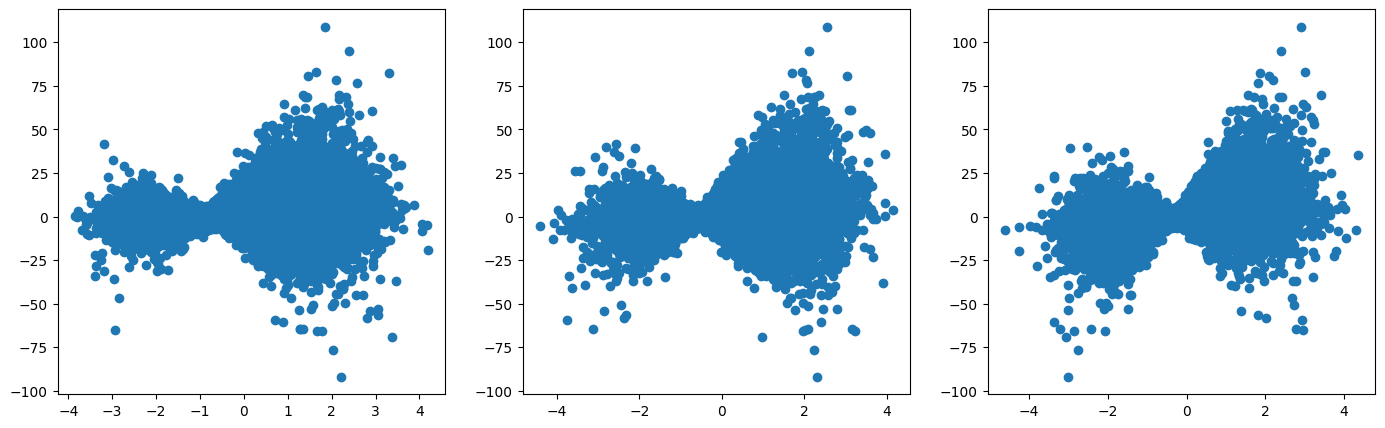

In [2]:
np.random.seed(123)
n = 75000
x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = np.random.normal(loc=0, scale=1, size=n)

b0 = .5
b1 = 1
b2 = 2# .6
b3 = 3
error = np.random.normal(loc=0, scale=1, size=n)
y = b0 + b1*x1 + b2*x2 + b3*x3 + 1*x1*x2 + 2*x1*x3 + 3*x2*x3 + 4*x1*x2*x3  + error

fig, ax = pyplot.subplots(nrows=1,ncols=3, figsize=(17,5))
ax[0].scatter(x1, y)
ax[1].scatter(x2, y)
ax[2].scatter(x3, y)
pyplot.show()

Sparseness level: [0.9 0.1]
[0]	validation_0-aucpr:0.95011	validation_1-aucpr:0.89829
[1]	validation_0-aucpr:0.96371	validation_1-aucpr:0.92311
[2]	validation_0-aucpr:0.96983	validation_1-aucpr:0.93428
[3]	validation_0-aucpr:0.97408	validation_1-aucpr:0.94267
[4]	validation_0-aucpr:0.97699	validation_1-aucpr:0.94595
[5]	validation_0-aucpr:0.97800	validation_1-aucpr:0.94762
[6]	validation_0-aucpr:0.97829	validation_1-aucpr:0.94736
[7]	validation_0-aucpr:0.98075	validation_1-aucpr:0.95409
[8]	validation_0-aucpr:0.98079	validation_1-aucpr:0.95475
[9]	validation_0-aucpr:0.98123	validation_1-aucpr:0.95518
[10]	validation_0-aucpr:0.98222	validation_1-aucpr:0.95704
[11]	validation_0-aucpr:0.98272	validation_1-aucpr:0.95759
[12]	validation_0-aucpr:0.98349	validation_1-aucpr:0.95886
[13]	validation_0-aucpr:0.98513	validation_1-aucpr:0.96119
[14]	validation_0-aucpr:0.98551	validation_1-aucpr:0.96187
[15]	validation_0-aucpr:0.98660	validation_1-aucpr:0.96345
[16]	validation_0-aucpr:0.98686	valida

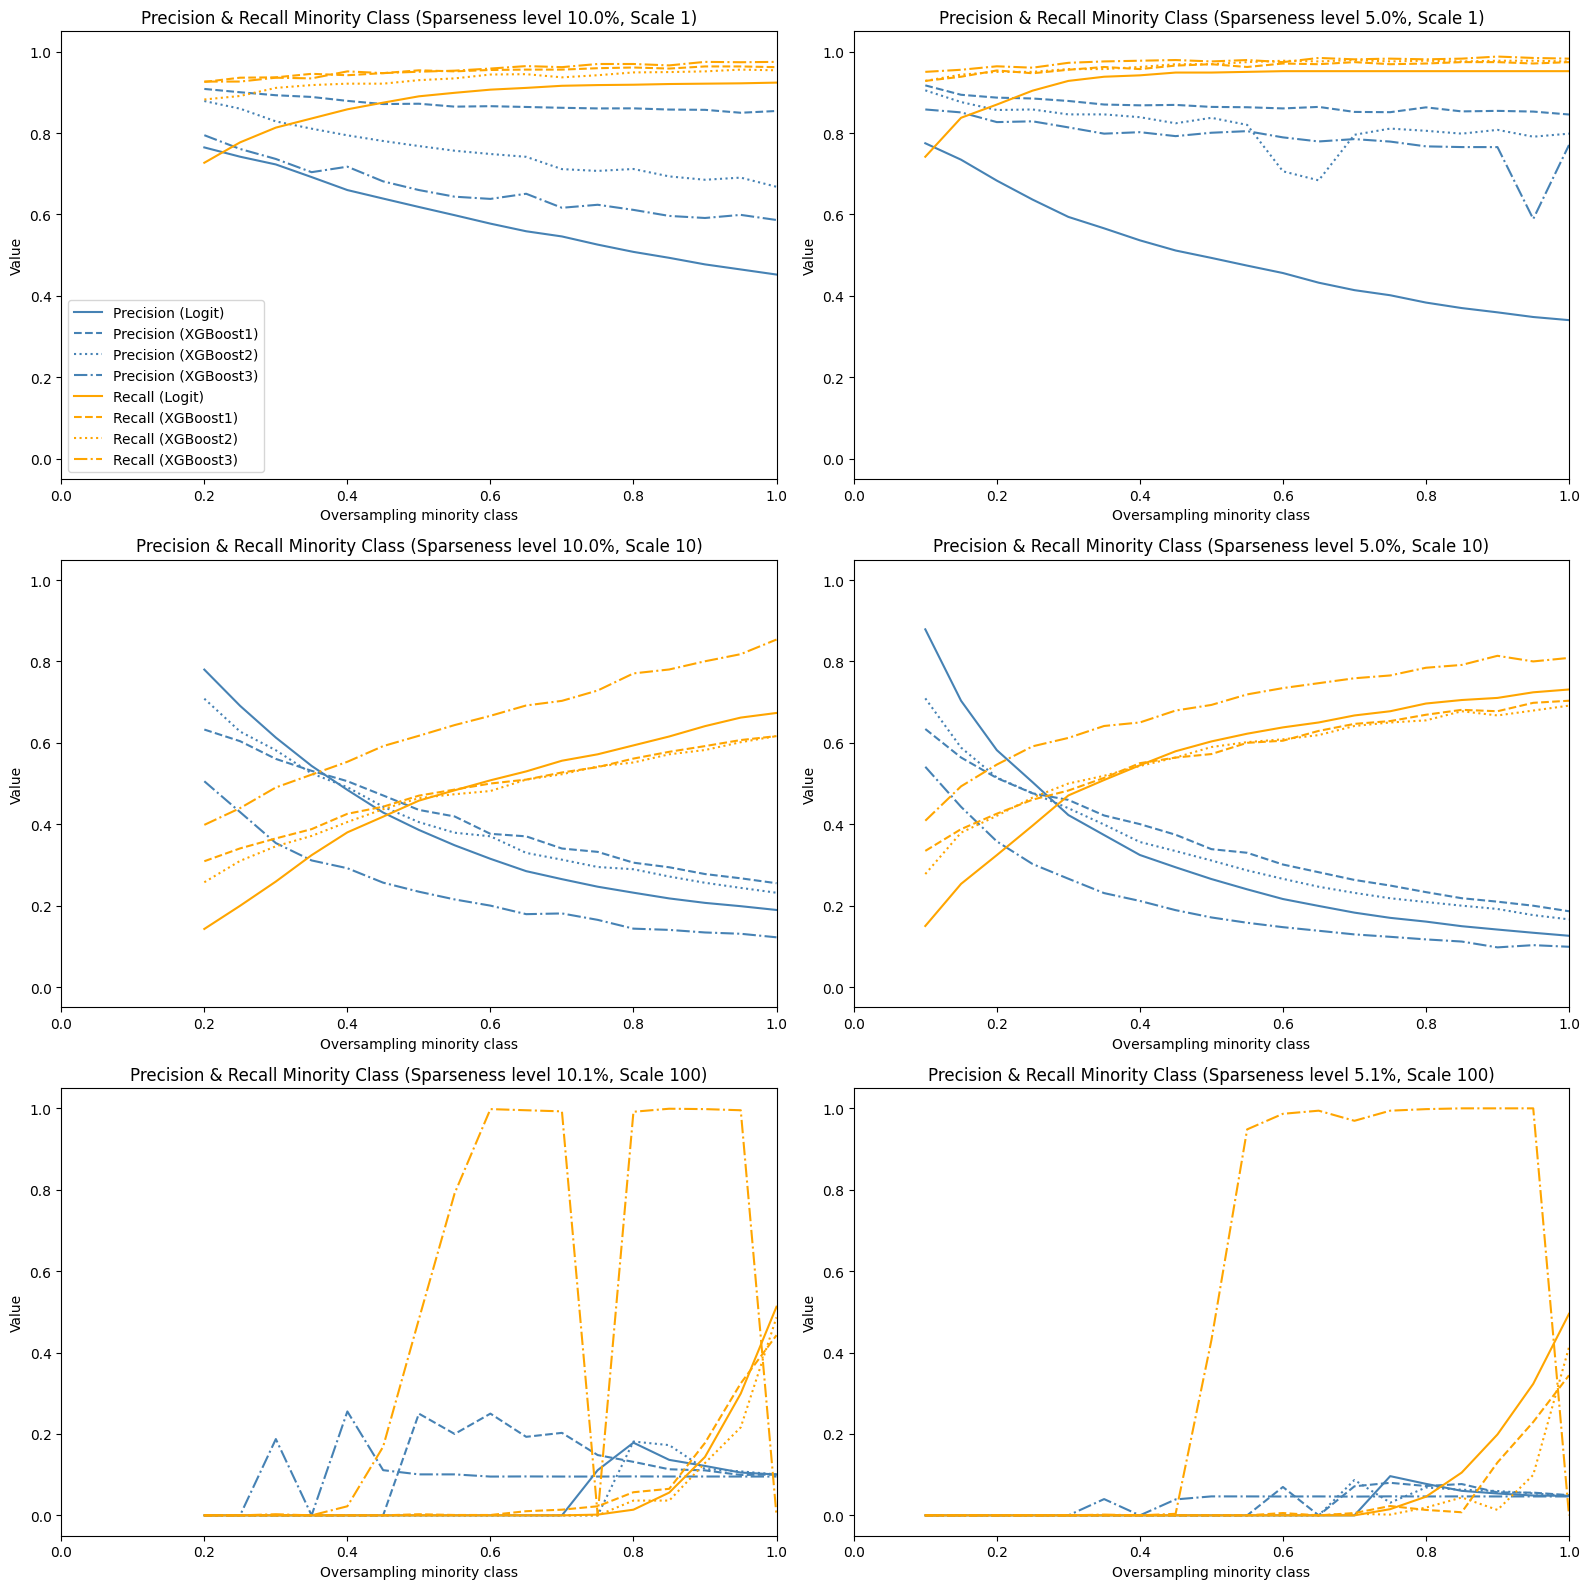

In [3]:
# control sparseness level of binary outcome variable through threshold
# loop through sparsenss levels, then SMOTE strategies
errr_lvls = [1,10,100]

fig, axes = pyplot.subplots(len(errr_lvls), 2, figsize=(16, 16)) # 5 * len(thresholds))

# instantiate models
nestimators = 10000
learning_rate = .06
early_stopping_rounds = 50
glm = LogisticRegression()

for i in range(len(errr_lvls)):
    error = np.random.normal(loc=0, scale=10, size=n)
    y = b0 + b1*x1 + b2*x2 + b3*x3 + 1*x1*x2 + 2*x1*x3 + 3*x2*x3 + 4*x1*x2*x3  + np.random.normal(loc=0, scale=errr_lvls[i], size=n)
    thresholds = list(np.quantile(y, [.9, 0.95]))
    for j in range(len(thresholds)): 
        ybin = y.copy()
        ybin[y < thresholds[j]] = 0
        ybin[y >= thresholds[j]] = 1
        print("Sparseness level:", np.unique(ybin, return_counts=True)[1] / len(ybin))

        X = np.column_stack((x1, x2,x3))
        X_train, X_tmp, y_train, y_tmp = train_test_split(X, ybin, random_state=123, shuffle=True,  test_size=.3) # stratify=y,
        X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, random_state=123, shuffle=True,  test_size=.5) 
        sparseness_train = np.unique(y_train, return_counts=True)[1] /len(y_train)
        sparseness_test = np.unique(y_test, return_counts=True)[1] /len(y_test)

        neg_count = sum(y_train == 0)
        pos_count = sum(y_train == 1)
        scale_pos_weight = neg_count / pos_count  # Balancing factor
        xgbre1 = XGBClassifier(n_estimators=nestimators
                               , max_depth=6
                               , min_child_weight=1
                               , gamma=0
                               , subsample=1
                               , colsample_bytree=1
                               , learning_rate=learning_rate
                               , objective='binary:logistic'
                               , early_stopping_rounds=early_stopping_rounds
                               , eval_metric = 'aucpr'
                               #, scale_pos_weight=scale_pos_weight
                               )

        xgbre2 = XGBClassifier(n_estimators=nestimators
                               , max_depth=4
                               , min_child_weight=5
                               , gamma=1.0
                               , subsample=.8
                               , colsample_bytree=.8
                               , learning_rate=learning_rate
                               , objective='binary:logistic'
                               , early_stopping_rounds=early_stopping_rounds
                               , eval_metric = 'aucpr'
                               #, scale_pos_weight=2# scale_pos_weight
                               )


        xgbre3 = XGBClassifier(n_estimators=nestimators
                               , max_depth=4
                               , min_child_weight=5
                               , gamma=1.0
                               , subsample=.8
                               , colsample_bytree=.8
                               , learning_rate=learning_rate
                               , objective='binary:logistic'
                               , early_stopping_rounds=early_stopping_rounds
                               , eval_metric = 'aucpr'
                               , scale_pos_weight=2# scale_pos_weight
                               )


        limit = np.max([sparseness_train[1], sparseness_test[1]])
        limit = np.round(limit + .05, 1)

        smote_strategies = np.arange(limit, 1.05, 0.05)
        smote_strategies = np.round(smote_strategies,2)
        precision_vec_raw_dat_glm = []
        precision_vec_raw_dat_xgbre1 = []
        precision_vec_raw_dat_xgbre2 = []
        precision_vec_raw_dat_xgbre3 = []
        recall_vec_raw_dat_glm = []
        recall_vec_raw_dat_xgbre1 = []
        recall_vec_raw_dat_xgbre2 = []
        recall_vec_raw_dat_xgbre3 = []

        for strg in smote_strategies:
            smt = SMOTE(random_state=42
                        , sampling_strategy=strg) # skipping sampling strategy: n_0s=n_1s

            # smote: internal method separates fit and transform
            smt.fit(X_train, y_train)
            X_train_smt, y_train_smt = smt._fit_resample(X_train, y_train)
            X_val_smt, y_val_smt = smt._fit_resample(X_val, y_val) 

            glm.fit(X_train_smt, y_train_smt)
            xgbre1.fit(X_train_smt, y_train_smt, eval_set=[(X_train_smt, y_train_smt), (X_val, y_val)])
            xgbre2.fit(X_train_smt, y_train_smt, eval_set=[(X_train_smt, y_train_smt), (X_val, y_val)])
            xgbre3.fit(X_train_smt, y_train_smt, eval_set=[(X_train_smt, y_train_smt), (X_val, y_val)])

            preds_sm = glm.predict(X_test)
            out = pd.crosstab(preds_sm, y_test)

            if 1.0 in out.index and 0 in out.columns:
                fp = np.array(out.loc[1.0, 0])  # False Positives
            else:
                fp = np.array(0)

            if 1.0 in out.index and 1.0 in out.columns:
                tp = np.array(out.loc[1.0, 1])  # True Positives
            else:
                tp = np.array(0)

            if 1.0 in out.columns and 0 in out.index:
                denominator_recall = tp + out.loc[0, 1.0]
                recall = tp / (denominator_recall) if denominator_recall != 0 else np.array(0)[0]
            else:
                recall = 0

            denominator_precision = tp + fp
            precision = tp / (denominator_precision + 1e-9) if denominator_precision != 0 else 0

            precision_vec_raw_dat_glm.append(precision)
            recall_vec_raw_dat_glm.append(recall)


            preds_sm = xgbre1.predict(X_test)
            out = pd.crosstab(preds_sm, y_test)

            if 1.0 in out.index and 0 in out.columns:
                fp = np.array(out.loc[1.0, 0])  # False Positives
            else:
                fp = np.array(0)

            if 1.0 in out.index and 1.0 in out.columns:
                tp = np.array(out.loc[1.0, 1])  # True Positives
            else:
                tp = np.array(0)

            if 1.0 in out.columns and 0 in out.index:
                denominator_recall = tp + out.loc[0, 1.0]
                recall = tp / (denominator_recall) if denominator_recall != 0 else np.array(0)[0]
            else:
                recall = 0

            denominator_precision = tp + fp
            precision = tp / (denominator_precision + 1e-9) if denominator_precision != 0 else 0

            precision_vec_raw_dat_xgbre1.append(precision)
            recall_vec_raw_dat_xgbre1.append(recall)



            preds_sm = xgbre2.predict(X_test)
            out = pd.crosstab(preds_sm, y_test)

            if 1.0 in out.index and 0 in out.columns:
                fp = np.array(out.loc[1.0, 0])  # False Positives
            else:
                fp = np.array(0)

            if 1.0 in out.index and 1.0 in out.columns:
                tp = np.array(out.loc[1.0, 1])  # True Positives
            else:
                tp = np.array(0)

            if 1.0 in out.columns and 0 in out.index:
                denominator_recall = tp + out.loc[0, 1.0]
                recall = tp / (denominator_recall) if denominator_recall != 0 else np.array(0)[0]
            else:
                recall = 0

            denominator_precision = tp + fp
            precision = tp / (denominator_precision + 1e-9) if denominator_precision != 0 else 0

            precision_vec_raw_dat_xgbre2.append(precision)
            recall_vec_raw_dat_xgbre2.append(recall)



            preds_sm = xgbre3.predict(X_test)
            out = pd.crosstab(preds_sm, y_test)

            if 1.0 in out.index and 0 in out.columns:
                fp = np.array(out.loc[1.0, 0])  # False Positives
            else:
                fp = np.array(0)

            if 1.0 in out.index and 1.0 in out.columns:
                tp = np.array(out.loc[1.0, 1])  # True Positives
            else:
                tp = np.array(0)

            if 1.0 in out.columns and 0 in out.index:
                denominator_recall = tp + out.loc[0, 1.0]
                recall = tp / (denominator_recall) if denominator_recall != 0 else np.array(0)[0]
            else:
                recall = 0

            denominator_precision = tp + fp
            precision = tp / (denominator_precision + 1e-9) if denominator_precision != 0 else 0

            precision_vec_raw_dat_xgbre3.append(precision)
            recall_vec_raw_dat_xgbre3.append(recall)


        axes[i,j].plot(smote_strategies, precision_vec_raw_dat_glm, c="steelblue", label="Precision (Logit)")
        axes[i,j].plot(smote_strategies, precision_vec_raw_dat_xgbre1, c="steelblue", label="Precision (XGBoost1)", linestyle = "dashed")
        axes[i,j].plot(smote_strategies, precision_vec_raw_dat_xgbre2, c="steelblue", label="Precision (XGBoost2)", linestyle = "dotted")
        axes[i,j].plot(smote_strategies, precision_vec_raw_dat_xgbre3, c="steelblue", label="Precision (XGBoost3)", linestyle = "dashdot")

        axes[i,j].plot(smote_strategies, recall_vec_raw_dat_glm, c="orange", label="Recall (Logit)")
        axes[i,j].plot(smote_strategies, recall_vec_raw_dat_xgbre1, c="orange", label="Recall (XGBoost1)", linestyle = "dashed")
        axes[i,j].plot(smote_strategies, recall_vec_raw_dat_xgbre2, c="orange", label="Recall (XGBoost2)", linestyle = "dotted")
        axes[i,j].plot(smote_strategies, recall_vec_raw_dat_xgbre3, c="orange", label="Recall (XGBoost3)", linestyle = "dashdot")

        axes[0,0].legend()
        axes[i,j].set_xlabel("Oversampling minority class")
        axes[i,j].set_ylabel("Value")
        axes[i,j].set_title(f"Precision & Recall Minority Class (Sparseness level {np.round(sparseness_train[1]*100,1)}%, Scale {errr_lvls[i]})")
        axes[i,j].set_ylim((-0.05, 1.05))
        axes[i,j].set_xlim((0, 1))

pyplot.tight_layout()
pyplot.show()


In [4]:
smt = SMOTE(random_state=42, sampling_strategy=.3) # skipping sampling strategy: n_0s=n_1s
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print(X_train_smt.shape)
glm = LogisticRegression()
glm.fit(X_train_smt, y_train_smt)
preds_sm = glm.predict(X_test)
pd.crosstab(preds_sm, y_test)

(64780, 3)


col_0    0.0  1.0
row_0            
0.0    10727  523

(62787, 3)
[0]	validation_0-aucpr:0.22603	validation_1-aucpr:0.05253
[1]	validation_0-aucpr:0.24982	validation_1-aucpr:0.05738
[2]	validation_0-aucpr:0.25495	validation_1-aucpr:0.05702
[3]	validation_0-aucpr:0.25876	validation_1-aucpr:0.05833
[4]	validation_0-aucpr:0.25837	validation_1-aucpr:0.05890
[5]	validation_0-aucpr:0.26030	validation_1-aucpr:0.05902
[6]	validation_0-aucpr:0.26103	validation_1-aucpr:0.05867
[7]	validation_0-aucpr:0.26143	validation_1-aucpr:0.05817
[8]	validation_0-aucpr:0.26249	validation_1-aucpr:0.05819
[9]	validation_0-aucpr:0.26128	validation_1-aucpr:0.05812
[10]	validation_0-aucpr:0.26430	validation_1-aucpr:0.05816
[11]	validation_0-aucpr:0.26494	validation_1-aucpr:0.05770
[12]	validation_0-aucpr:0.26362	validation_1-aucpr:0.05904
[13]	validation_0-aucpr:0.26462	validation_1-aucpr:0.05857
[14]	validation_0-aucpr:0.26475	validation_1-aucpr:0.05833
[15]	validation_0-aucpr:0.26695	validation_1-aucpr:0.05847
[16]	validation_0-aucpr:0.26797	validation_1-aucpr:0.05

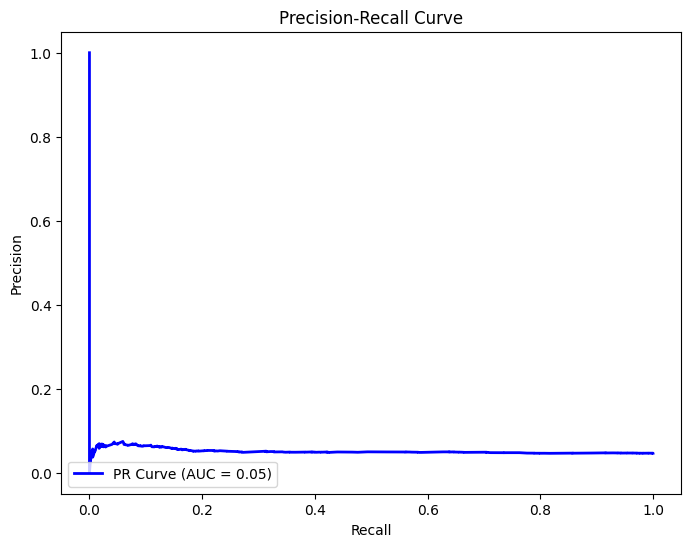

In [5]:
smt = SMOTE(random_state=42, sampling_strategy=.26) 
smt.fit(X_train, y_train)
X_train_smt, y_train_smt = smt._fit_resample(X_train, y_train)
print(X_train_smt.shape)
X_val_smt, y_val_smt = smt._fit_resample(X_val, y_val)

xgbre2.fit(X_train_smt, y_train_smt, eval_set=[(X_train_smt, y_train_smt), (X_val, y_val)])
preds_sm = xgbre2.predict(X_test)
pred_probas_xgb = xgbre2.predict_proba(X_test)[:, 1]
print(pd.crosstab(preds_sm, y_test))


precision, recall, _ = precision_recall_curve(y_test, pred_probas_xgb)
pr_auc = auc(recall, precision)

# Plot PR Curve
pyplot.figure(figsize=(8,6))
pyplot.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall Curve')
pyplot.legend(loc='lower left')
pyplot.show()
